# References

1. Tutorial and Sample Code for Balancing a Pole on a Cart: https://github.com/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb 
2. Detailed Explanation and Python Implementation of the Q-Learning Algorithm with Tests in Cart Pole OpenAI Gym Environment – Reinforcement Learning Tutorial”. Technical Report, Number 6, Aleksandar Haber, (2023), Publisher: www.aleksandarhaber.com, Link: https://aleksandarhaber.com/q-learning-in-python-with-tests-in-cart-pole-openai-gym-environment-reinforcement-learning-tutorial/
3. Temporal Difference Learning: SARSA vs Q-learning: https://medium.com/codex/temporal-difference-learning-sarsa-vs-q-learning-c367934b8bcc
4. Cart Pole Gym Documentation: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

# Installing Dependencies
Run:

conda env create -f environment.yml

conda activate sc3000_project

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import pandas as pd

## Loading Cartpole environment

In [2]:
env = gym.make("CartPole-v1")

For the action space, it is a ndarray with shape (1,) which can take values {0,1}:
- 0 : Push cart to the left
- 1 : Push cart to the right 

In [3]:
actionNumber = env.action_space.n
print(actionNumber)

2


For the observation space, it is a ndarray with shape (4,) with the corresponding values:
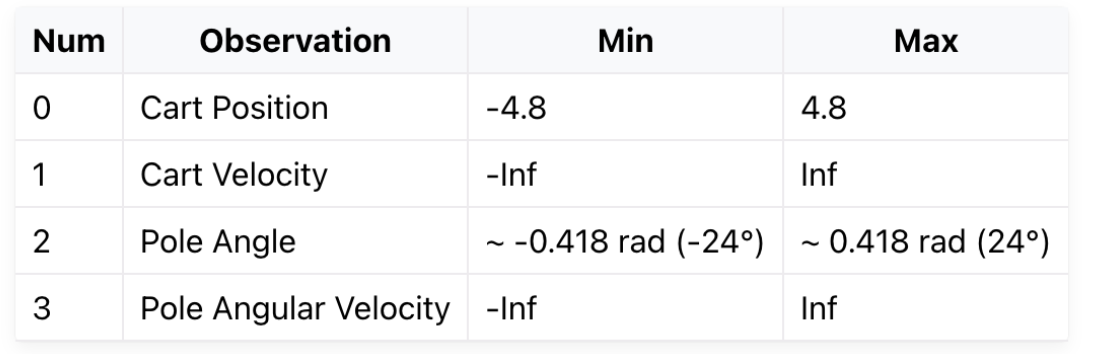

In [4]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


# Task 1: Development of an RL agent
## Approach

We decided to use **Q-learning** with temporal difference (Epsilon-Greedy with a decaying epsilon). This was optimized using a custom method of hyperparameter selection and analysis. Our investigation focused on different hyperparameters and thereafter record the rewards produced by various configurations to choose the best values for each parameters in training the RL agent to eventually give the best average reward.

## Improving the RL Agent

Starting off this project, it is not apparent which set of values for the hyperparameters will work best. By systematically experimenting with different combinations, we can observe which hyperparameters will fail to converge effectively and which would lead to higher rewards.

## Step 1: Defining the hyperparameter

gamma: Discount factor that influences how much the agent values future rewards compared to the immediate ones. A value closer to 1 encourages the agent to consider long-term outcomes, while a value closer to 0 biases it towards immediate gains. It was found setting gamma closer to 1 would increase the reward, hence we set it to between 0.9 to 1.0

noOfEpisodesForRandom: Varies the number of episodes for random exploration during the training phase

numberOfBins: Controls the discretization of the continuous state space. A higher number of bins allows finer granularity in distinguishing states, but can increase complexity in the Q-table or learning algorithm.

epsilon: The exploration rate represents the probability of an agent exploring, or choosing a random action instead of the action it believes is optimal based on its current knowledge

alpha: The learning rate that determines how quickly new information overrides old knowledge. A higher alpha emphasizes faster adaptation to recent experiences by relying on recent experiences, though too high a value risks forgetting useful past behaviors.

In [5]:
hyperparameter_space = {
    'gamma': np.linspace(0.9, 1, 10),
    'noOfEpisodesForRandom': np.linspace(300, 600, 5, dtype=int),
    'numberOfBins': np.linspace(25, 30, 5, dtype=int),
    'epsilon': np.linspace(0.1, 0.4, 5),
    'alpha': np.linspace(0.1, 0.4, 5),
}

To determine the best combination of hyperparameter values, we utilized a hyperparameter optimizer. We sampled these hyperparameters from our hyperparameter_space and stored them in sample_hyperparameters

In [6]:
sampled_hyperparameters = {
    'gamma': np.random.choice(hyperparameter_space['gamma']),
    'noOfEpisodesForRandom': np.random.choice(hyperparameter_space['noOfEpisodesForRandom']),
    'numberOfBins': np.random.choice(hyperparameter_space['numberOfBins']),
    'epsilon': np.random.choice(hyperparameter_space['epsilon']),
    'alpha': np.random.choice(hyperparameter_space['alpha'])
    }

## Step 2: Defining Q-matrix
The initialized multi-dimensional matrix “Qmatrix” is used to store the Q matrix and store the values of the action value function. We initialize the values of this matrix as random real numbers.

In [7]:
numberOfBins = sampled_hyperparameters["numberOfBins"]
Qmatrix = np.random.uniform(low=0, high=1, size=(numberOfBins ,numberOfBins,numberOfBins,numberOfBins,actionNumber))

## Step 3: Define functions needed


In [8]:
def discretiseState(state, numberOfBins):
  """
  Discretizes the continuous state variables of the CartPole environment into integer bins.

  Parameters
  ----------
  state : array-like of shape (4,)
      The environment state, typically [cart position, cart velocity, pole angle, pole angular velocity].
  numberOfBins : int
      The number of bins to use for each state dimension.

  Returns
  -------
  tuple of int
      A 4-tuple of indices representing the discretized state for use in a Qmatrix
  """

  # Initialise all bins with params (lowerbound, upperbound, number of bins)
  cartPositionBin = np.linspace(env.observation_space.low[0], env.observation_space.high[0], numberOfBins)
  cartVelocityBin = np.linspace(-3, 3, numberOfBins)
  poleAngleBin = np.linspace(env.observation_space.low[2], env.observation_space.high[2], numberOfBins)
  poleAngleVelocityBin = np.linspace(-10, 10, numberOfBins)

  # For each state, find which bin it falls under and return the index
  indexPosition=np.maximum(np.digitize(state[0], cartPositionBin) - 1, 0)
  indexVelocity=np.maximum(np.digitize(state[1], cartVelocityBin) - 1, 0)
  indexAngle=np.maximum(np.digitize(state[2], poleAngleBin) - 1, 0)
  indexAngularVelocity=np.maximum(np.digitize(state[3], poleAngleVelocityBin) - 1 , 0)

  # Tuple defining the indices in Qmatrix
  return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])

In [9]:
def epsilonGreedySelection(stateIndex, episodeNo, isTrain):
    """
    Selects an action for the CartPole agent using an epsilon-greedy strategy.

    Parameters
    ----------
    stateIndex : tuple of int
        The discretized state indices used to index the Q-table.
    episodeNo : int
        The current episode number.
    isTrain : bool
        Indicates whether the agent is in training mode.

    Returns
    -------
    int
        The chosen action (e.g., 0 for left, 1 for right).
    """
    # Extracting from the sampled_hyperparameters
    noOfEpisodesForRandom = sampled_hyperparameters['noOfEpisodesForRandom']
    epsilon = sampled_hyperparameters['epsilon']

    # Explore randomly for 'noOfEpisodesForRandom' episodes at the beginning (if training)
    if episodeNo < noOfEpisodesForRandom and isTrain:
        return np.random.choice(actionNumber)

    # After the initial random phase, gradually reduce epsilon to encourage exploitation
    if episodeNo > noOfEpisodesForRandom and isTrain:
        epsilon *= 0.9999

    # Epsilon = probability of choosing a random action
    actionToTake = np.random.random()

    # Return random action (0 or 1) if below epsilon threshold (exploration)
    if actionToTake < epsilon and isTrain:
        return np.random.choice(actionNumber)
    else:
        # Otherwise, choose the action with the highest Q-value
        bestAction = Qmatrix[stateIndex] == np.max(Qmatrix[stateIndex])
        return np.random.choice(np.where(bestAction)[0])

In [10]:
def temporalDifference(isTerminal, reward, stateIndex, statePrimeIndex, optimalAction):
    """
    Computes the updated Q-value for a given state-action pair using the Temporal Difference (TD) rule.

    Parameters
    ----------
    isTerminal : bool
        Indicates whether the next state is terminal. If True, future rewards are set to zero.
    reward : float
        The immediate reward received after taking the action.
    stateIndex : index type
        The index corresponding to the current discretized state.
    statePrimeIndex : index type
        The index corresponding to the next discretized state.
    optimalAction : int
        The action taken at the current state (assumed to be the optimal one in terms of Q-value).

    Returns
    -------
    float
        The updated Q-value for the state-action pair.
    """
    # Compute the maximum Q-value for the next state
    maxNextQ = np.max(Qmatrix[statePrimeIndex])
    
    # In terminal states, there are no future rewards
    if isTerminal:
        maxNextQ = 0

    # Retrieve hyperparameters for the update
    gamma = sampled_hyperparameters['gamma'] 
    alpha = sampled_hyperparameters['alpha']  

    # Calculate the TD error: difference between the current Q-value and the estimated target
    td_error = reward + (gamma * maxNextQ) - Qmatrix[stateIndex + optimalAction]

    # Update the Q-value with a fraction (alpha) of the TD error
    updatedQ = Qmatrix[stateIndex + optimalAction] + (alpha * td_error)

    return updatedQ

In [11]:
def simulateEpisodes(numberofEpisodes, isTrain):
    """
    Simulates a specified number of episodes in the CartPole environment using the current policy, updating the Q-table based on temporal difference learning.

    Parameters
    ----------
    numberofEpisodes : int
        The total number of episodes to simulate.
    isTrain : bool
        If True, the simulation is in training mode (enabling exploration); otherwise, it operates in evaluation mode.

    Returns
    -------
    list of float
        A list containing the cumulative reward for each episode.
    """
    # Get the discretization parameter from our hyperparameter settings
    numberOfBins = sampled_hyperparameters['numberOfBins']

    cumulativeRewards = []  # List to store the total reward from each episode
    for episodeNo in range(numberofEpisodes):
        state, _ = env.reset()
        state = list(state)
        episodeRewards = []  
        # Continue until the episode terminates or is truncated
        while True:
            stateIndex = discretiseState(state, int(numberOfBins))
            # Determine the action using the epsilon-greedy policy
            optimalAction = epsilonGreedySelection(stateIndex, episodeNo, isTrain)
            statePrime, reward, isTerminalState, truncated, _ = env.step(optimalAction)
            episodeRewards.append(reward)
            statePrimeIndex = discretiseState(statePrime, numberOfBins)
            # Update the Q-value for the current state-action pair using temporal difference learning
            Qmatrix[stateIndex + (optimalAction,)] = temporalDifference(isTerminalState, reward, stateIndex, statePrimeIndex, (optimalAction,))
            if isTerminalState or truncated:
                break
            state = statePrime
        totalReward = np.sum(episodeRewards)
        cumulativeRewards.append(totalReward)

    return cumulativeRewards


## Step 4: Random hyperparameter search to find the best values

In [12]:
# N is the number of iterations
N = 10

# Lists to store hyperparameter sets and their corresponding average rewards for each iteration
all_hyperparameters = []
all_avg_rewards = []

# Reiterate N times to obtain the best hyperparameters and its average reward
for i in range(N):

    print(f"\nIteration {i+1}/{N}")

    # Randomly sample hyperparameters from the search space
    sampled_hyperparameters = {
    'gamma': np.random.choice(hyperparameter_space['gamma']),
    'noOfEpisodesForRandom': np.random.choice(hyperparameter_space['noOfEpisodesForRandom']),
    'numberOfBins': np.random.choice(hyperparameter_space['numberOfBins']),
    'epsilon': np.random.choice(hyperparameter_space['epsilon']),
    'alpha': np.random.choice(hyperparameter_space['alpha'])
    }

    numberOfBins = sampled_hyperparameters["numberOfBins"]
    Qmatrix = np.random.uniform(low=0, high=1, size=(numberOfBins, numberOfBins, numberOfBins, numberOfBins, actionNumber))

    episodes_reward = simulateEpisodes(10000, True)

    avg_reward = np.mean(episodes_reward)

    all_hyperparameters.append(sampled_hyperparameters)
    all_avg_rewards.append(avg_reward)

print("Hyperparameter for each iteration computed!")


Iteration 1/10

Iteration 2/10

Iteration 3/10

Iteration 4/10

Iteration 5/10

Iteration 6/10

Iteration 7/10

Iteration 8/10

Iteration 9/10

Iteration 10/10
Hyperparameter for each iteration computed!


In [13]:
results_df = pd.DataFrame({
    'gamma': [float(hp['gamma']) for hp in all_hyperparameters],
    'noOfEpisodesForRandom': [int(hp['noOfEpisodesForRandom']) for hp in all_hyperparameters],
    'numberOfBins': [int(float(hp['numberOfBins'])) for hp in all_hyperparameters],
    'epsilon': [float(hp['epsilon']) for hp in all_hyperparameters],
    'alpha': [float(hp['alpha']) for hp in all_hyperparameters],
    'reward': all_avg_rewards
})

df = results_df.sort_values(by='reward', ascending=False)

print("\nHyperparameter Sets from highest to lowest reward:")
print(df)



Hyperparameter Sets from highest to lowest reward:
      gamma  noOfEpisodesForRandom  numberOfBins  epsilon  alpha    reward
2  0.977778                    450            27    0.100  0.400  166.8950
9  0.933333                    450            27    0.175  0.250  154.4629
0  0.988889                    450            30    0.250  0.325  141.8974
4  0.977778                    525            30    0.100  0.175  141.5036
7  0.933333                    600            28    0.175  0.250  130.5411
8  0.977778                    450            28    0.175  0.100  119.6617
5  0.933333                    375            26    0.325  0.175  119.5151
6  0.955556                    525            27    0.325  0.250  119.1476
3  0.944444                    600            30    0.175  0.100  116.5781
1  0.944444                    300            26    0.325  0.100  101.0016


## Step 5: Selecting the best hyperparameter to train the q learning model

In [ ]:
# Getting the best hyperparameters from the DataFrame
best_hyperparameters = df.iloc[0]

best_hyperparameters = {
    'gamma': float(best_hyperparameters['gamma']),
    'noOfEpisodesForRandom': int(best_hyperparameters['noOfEpisodesForRandom']),
    'numberOfBins': int(best_hyperparameters['numberOfBins']),  
    'epsilon': float(best_hyperparameters['epsilon']),
    'alpha': float(best_hyperparameters['alpha'])
}

numberOfBins = best_hyperparameters["numberOfBins"]
sampled_hyperparameters = best_hyperparameters
Qmatrix = np.random.uniform(low=0, high=1, size=(numberOfBins ,numberOfBins,numberOfBins,numberOfBins,actionNumber))

# Run Q-learning with the best hyperparameters over 30000 episodes
sumOfRewards = simulateEpisodes(30000, True)

print("Training Done")


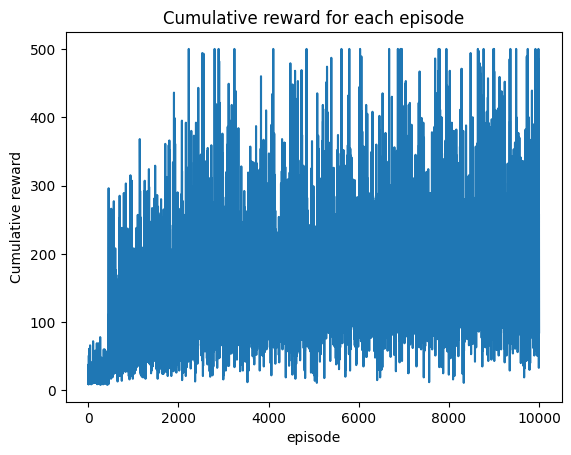

In [15]:
plt.plot(episodes_reward)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [16]:
def agent(observation):
    stateIndex = discretiseState(observation, best_hyperparameters["numberOfBins"])
    return np.argmax(Qmatrix[stateIndex])

observation, _ = env.reset()
action = agent(observation)
print("Observation:", observation)
print("Chosen action:", action)


Observation: [-0.02772219 -0.03489357  0.0136876  -0.04909436]
Chosen action: 0


# Task 2: Effectiveness of RL agent over 100 episodes

Average Reward: 405.36


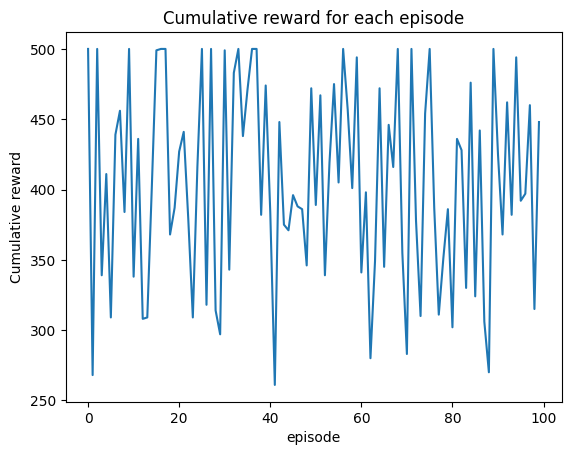

In [27]:
newRewards = simulateEpisodes(100, False)  


avgNewReward = np.mean(newRewards)
print("Average Reward: " + str(avgNewReward))
plt.plot(newRewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

# Task 3: Rendering one episode played by the RL agent

In [31]:
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data=f'''
            <video alt="test" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
            </video>
        '''))
    else:
        print("Could not find video")
        
env = RecordVideo(
    gym.make("CartPole-v1", render_mode='rgb_array'),
    "./video",
    episode_trigger=lambda x: x == 0 
)

observation, _ = env.reset()

while True:
    action = agent(observation)
    observation, reward, done, _, _ = env.step(action)
    
    if done:
        break

env.close()
show_video()


MoviePy - Building video /Users/justinl/Desktop/SC3000-AI/video/rl-video-episode-0.mp4.
MoviePy - Writing video /Users/justinl/Desktop/SC3000-AI/video/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /Users/justinl/Desktop/SC3000-AI/video/rl-video-episode-0.mp4
